<a href="https://colab.research.google.com/github/nataliecalosa/portfolio/blob/main/Options%20Price%20Modelling%20with%20GBM%2C%20Binomial%2C%20Monte%20Carlo%20Methods%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import random

#Data

In [ ]:
#Data

# Create a Ticker object for JPM
stock = yf.Ticker("JPM")

# Define the start and end dates for the historical stock prices
start_date = datetime(2022, 2, 1)
end_date = datetime(2023, 2, 1)

# Set the frequency to "1mo" to retrieve monthly data
freq = "1mo"

# Get the historical stock prices for JPM with monthly frequency
data= stock.history(start=start_date, end=end_date, interval=freq)
s0=(stock.history('2023-04-01'))["Close"]
data=data["Close"]

#Data Strike Price

# Prompt the user to select an expiration date
expiration_date = '2023-04-14'
# Get the options for the selected expiration date
option = yf.Ticker("JPM").option_chain(expiration_date)

# Get the strike prices for call and put options
call_strikes = option.calls.strike.values
put_strikes = option.puts.strike.values

#harga put dan call yang dipilih
KC=np.random.choice(call_strikes, size=2, replace=False)
KP1=np.random.choice(put_strikes, size=1, replace=False)
K=[KC[0],KC[1],KP1[0]]
print(K)

[129.0, 136.0, 126.0]


In [ ]:
# Hitung rata-rata return dan volatilitas log-return
returns = np.log(data.pct_change() + 1) # pct_change() adalah method yang dapat digunakan pada objek Series untuk menghitung persentase perubahan antara setiap nilai pada Series dengan nilai sebelumnya, Penambahan 1 dalam fungsi pct_change() + 1 dilakukan agar perhitungan log-return dapat dilakukan dengan aman (agar tidak terjadi pembagian dengan nilai 0).
mean_return = np.mean(returns)
std_dev = np.std(returns)

# Hitung drift dan volatilitas GBM
drift = (mean_return + 0.5 * std_dev ** 2)* np.sqrt(1/12)
volatility = std_dev * np.sqrt(1/12) #12 bulan

#GBM

Untuk Periode ke- 1
              0
0.000000  129.0
0.000000  136.0
2.582414  126.0
Untuk Periode ke- 3
            0
0.0000  129.0
0.0000  136.0
1.8333  126.0
Untuk Periode ke- 6
             0
0.00000  129.0
0.00000  136.0
0.61417  126.0


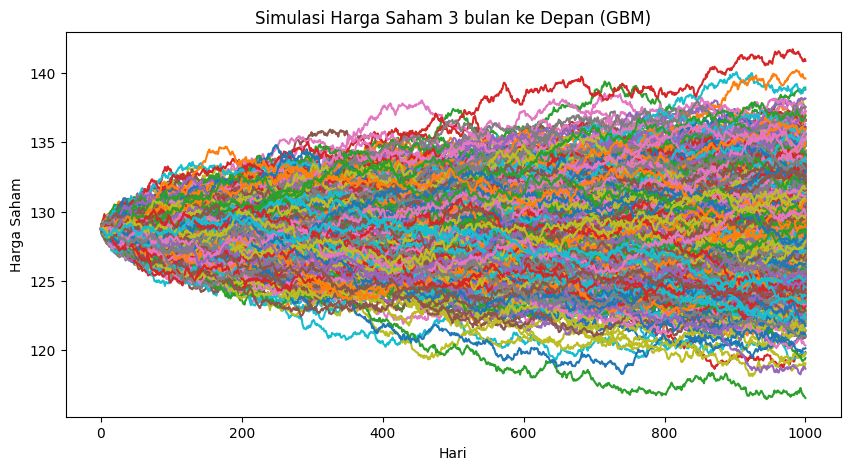

In [ ]:
#Definisi fungsi untuk menghitung harga opsi dengan gerak brown geometrik 
def GBM(t_sim,n_sim,s0,r,K):
  # Hitung prediksi harga saham dengan metode GBM
  t = t_sim/1000 #prediksi harga saham perhari
  stock_mean=[] 
  #dilakukan simulasi gerak brown geometrik sebanyak 1000 kali untuk mencari 1000 rata-rata harga saham (monte carlo) agar harga saham yang digunakan lebih tepat
  for k in range (n_sim):
    #algoritma satu simulasi gerak brown geometrik dengan grafik lintasan saham 1000  buah
    simulations = np.zeros((n_sim, (1000)+1))
    simulations[:, 0] = s0
    for i in range(1, (1000)+1):
        random_numbers = np.random.normal(0, 1, n_sim)
        drift_component = (drift - 0.5 * volatility ** 2) * t
        volatility_component = volatility * np.sqrt(t) * random_numbers
        simulations[:, i] = simulations[:, i-1] * np.exp(drift_component + volatility_component)
    #menghitung rata-rata nilai saham terakhir untuk setiap 1 simulasi GBM
    stock_mean.append(np.mean(simulations[:,t_sim*30]))
  if K=="K[2]": #put
    C_GBM = [max(K-(stock_mean[j]),0) for j in range (n_sim)]
  else:
    C_GBM = [max((stock_mean[j]-K),0) for j in range (n_sim)]
  #menghitung harga opsi
  C=np.exp(-r*t_sim)*np.mean(C_GBM)
  return(simulations,C)


n_sim = 1000 # Jumlah simulasi
r= 0.475 #https://www.cnbc.com/2023/03/22/live-updates-fed-rate-march.html
t_sim=[1,3,6]

def c(periode):
    r1 = ((((1 + r)**(periode/12))-1))
    GBM_C1 = GBM(1, n_sim, s0, r1, K[0])
    GBM_C2 = GBM(1, n_sim, s0, r1, K[1])
    GBM_P1 = GBM(1, n_sim, s0, r1, K[2])
    harga_saham = [GBM_C1[0], GBM_C2[0], GBM_P1[0]]
    harga_opsi = [float(GBM_C1[1])*(np.exp(-r1*periode)), float(GBM_C2[1])*(np.exp(-r1*periode)), float(GBM_P1[1])*(np.exp(-r1*periode))]
    return(harga_saham, harga_opsi)

#Output
output=[c(t_sim[0]),c(t_sim[1]),c(t_sim[2])]
for i in range (3):
  print("Untuk Periode ke-", t_sim[i])
  df1 = pd.DataFrame(K,output[i][1])
  print(df1)

# Visualisasi simulasi harga saham
plt.figure(figsize=(10, 5))
plt.plot(((output[2])[0])[1].T)
plt.title('Simulasi Harga Saham 3 bulan ke Depan (GBM)')
plt.xlabel('Hari')
plt.ylabel('Harga Saham')
plt.show()

#Binomial

In [ ]:
def bin(t_sim,N,s0,r,K):
  delta_t = t_sim/N
  betta = 0.5*(np.exp(-r*delta_t)+np.exp((r+volatility**2)*delta_t))
  u = np.exp(betta * np.sqrt(delta_t))
  d = 1/u

  # Menghitung probabilitas naik (p) dan probabilitas turun (q)
  p = (np.exp(r * delta_t) - d)/(u - d)
  q = 1 - p

  # Membuat array untuk menyimpan harga saham di setiap langkah waktu
  S = np.zeros((N+1, N+1))

  # Mengisi array S dengan harga saham di setiap langkah waktu
  S[0,0] = s0
  for i in range(1, N+1):
      S[i,0] = S[i-1,0] * u
      for j in range(1, i+1):
          S[i,j] = S[i-1,j-1] * d
  #Menghitung harga opsi
  #Menghitung payoff
  C_bin=np.zeros((N+1,N+1))
  for j in range (N+1):
    C_bin[N,j]=max(S[N,j]-K,0)
  #induksi mundur
  for i in range (N-1,-1,-1):
    for j in range (i+1):
      C_bin[i,j]=(np.exp(-r*delta_t)*(p*C_bin[i+1,j]+(1-p)*C_bin[i+1,j+1]))
  V=C_bin[0,0]
  return (S,V)

In [ ]:
n_sim = 1000 # Jumlah simulasi
r= 0.475 #https://www.cnbc.com/2023/03/22/live-updates-fed-rate-march.html
t_sim=[1,3,6]

def c(periode):
    r1 = ((((1 + r)**(periode/12))-1))
    bin_C1 = bin(1, n_sim, s0, r1, K[0])
    bin_C2 = bin(1, n_sim, s0, r1, K[1])
    bin_P1 = bin(1, n_sim, s0, r1, K[2])
    harga_saham = [bin_C1[0], bin_C2[0], bin_P1[0]]
    harga_opsi = [float(bin_C1[1])*(np.exp(-r1*periode)), float(bin_C2[1])*(np.exp(-r1*periode)), float(bin_P1[1])*(np.exp(-r1*periode))]
    return(harga_saham, harga_opsi)
#Output
output=[c(t_sim[0]),c(t_sim[1]),c(t_sim[2])]

#Output
output=[c(t_sim[0]),c(t_sim[1]),c(t_sim[2])]
for i in range (3):
  print("Untuk Periode ke-", t_sim[i])
  df1 = pd.DataFrame(K,output[i][1])
  print(df1)

Untuk Periode ke- 1
               0
48.889175  129.0
46.864273  136.0
49.815227  126.0
Untuk Periode ke- 3
               0
39.238779  129.0
37.685622  136.0
39.947028  126.0
Untuk Periode ke- 6
               0
15.963679  129.0
15.377955  136.0
16.229541  126.0


#Black Scholes

In [ ]:
#black_scholes
from scipy.stats import norm
n_sim = 1000 # Jumlah simulasi
r= 0.475 #https://www.cnbc.com/2023/03/22/live-updates-fed-rate-march.html
t_sim=[1,3,6]

def black_scholes(T,S, r,K,sigma, option_type):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

def c(periode):
    r1 = ((((1 + r)**(periode/12))-1))
    C1 = black_scholes(periode, s0, r1, K[0],volatility,'call')
    C2 = black_scholes(periode, s0, r1, K[1],volatility,'call')
    P1 = black_scholes(periode, s0, r1, K[2],volatility,'put')
    harga_opsi = [C1*((1/(1+r1))**periode), C2*((1/(1+r1))**periode), P1*((1/(1+r1))**periode)]
    return(harga_opsi)

#Output
output=[c(t_sim[0]),c(t_sim[1]),c(t_sim[2])]

#Output
output=[c(t_sim[0]),c(t_sim[1]),c(t_sim[2])]
for i in range (3):
  print("Untuk Periode ke-", t_sim[i])
  print(output[i])

Untuk Periode ke- 1
[Date
2023-03-30 00:00:00-04:00    4.067959
Name: Close, dtype: float64, Date
2023-03-30 00:00:00-04:00    0.484028
Name: Close, dtype: float64, Date
2023-03-30 00:00:00-04:00    0.042746
Name: Close, dtype: float64]
Untuk Periode ke- 3
[Date
2023-03-30 00:00:00-04:00    25.22965
Name: Close, dtype: float64, Date
2023-03-30 00:00:00-04:00    21.378809
Name: Close, dtype: float64, Date
2023-03-30 00:00:00-04:00    2.845744e-11
Name: Close, dtype: float64]
Untuk Periode ke- 6
[Date
2023-03-30 00:00:00-04:00    29.02185
Name: Close, dtype: float64, Date
2023-03-30 00:00:00-04:00    28.419574
Name: Close, dtype: float64, Date
2023-03-30 00:00:00-04:00    4.102332e-76
Name: Close, dtype: float64]
